##### Copyright 2022 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction

Thank you for joining the MediaPipe workshop at Women in ML Symposium 2022. This document will help you follow along with the live coding section in the workshop. In this section, you will learn:
* How to use MediaPipe Studio to try out on-device ML solutions on the web without writing a single line of code.
* How to integrate the solutions into your application using MediaPipe Tasks
* How to customize solutions using MediaPipe Model Maker.


# Step 1: Try out off-the-shelf solution in MediaPipe Studio

MediaPipe Studio allows you to try out on-device ML solutions that we support right in a web browser without having to write any code. Follow these steps to check it out:

1. Go to the MediaPipe Studio's [Gesture Recognizer demo](https://mediapipe-studio.webapps.google.com/demo/gesture_recognizer).
1. Try out the 7 gestures that the off-the-shelf model recognizes: 👍, 👎, ✌️, ☝️, ✊, 👋, 🤟
![Studio screenshot](https://storage.googleapis.com/khanhlvg_ml/wimls_22/studio_screenshot.jpg)
1. Check out demos of other on-device ML use cases on [goo.gle/mediapipe-studio](https://goo.gle/mediapipe-studio).

# Step 2: Use the off-the-shelf solution in Python with MediaPipe Tasks

Now you know what the off-the-shelf solution can do. Let’s go write some Python code to integrate it in a Python application using MediaPipe Tasks.

## Preparation

We start with installing MediaPipe pip package.

*Note: If you see an error about `flatbuffers` incompatibility, it's fine to ignore it. MediaPipe requires a newer version of flatbuffers (v2), which is incompatible with the older version of Tensorflow (v2.9) currently preinstalled on Colab.*

In [ ]:
!pip install -q flatbuffers==2.0.0
!pip install -q mediapipe==0.9.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 2.0 which is incompatible.
     |████████████████████████████████| 33.0 MB 2.7 MB/s 


Then we download [the off-the-shelf gesture recognizer model bundle](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer#models) that can recognize 7 different gestures: 👍, 👎, ✌️, ☝️, ✊, 👋, 🤟 .

The model bundle contains multiple TensorFlow Lite models that are chained together to perform gesture recognition on images.

In [ ]:
!wget -O gesture_recognizer.task -q https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/gesture_recognizer.task

## Download a test image with hand gesture

Let's download a test image and recognize the hand gesture in the image.

If you want to take a photo with your webcam, please skip to the next code cell.

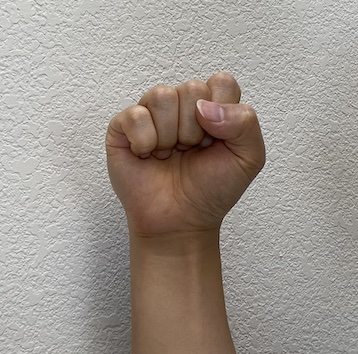

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

!wget -q -O photo.jpg https://storage.googleapis.com/khanhlvg_ml/wimls_22/fist.jpg

img = cv2.imread("photo.jpg")
cv2_imshow(img)

In [ ]:
#@markdown ## Optional: Capture a test image with your webcam

#@markdown You can also take a photo of your a hand gesture with your webcam and we'll try to recognize it using MediaPipe. If you want to do so, run this cell and you will be asked to allow Colab accessing your camera to capture a test image.

#@markdown *Note: The code snippet below can be added by selecting `Code snippets` > `Camera Capture` on Colab.*

#@markdown ![Colab screenshot](https://storage.googleapis.com/khanhlvg_ml/wimls_22/colab_screen_capture.jpg)

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Recognize gesture from the image using MediaPipe

You can recognize the gesture in the image in just a few lines of code.

In [ ]:
# Imports neccessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os

# Create a GestureRecognizer object.
model_path = os.path.abspath("gesture_recognizer.task")
recognizer = vision.GestureRecognizer.create_from_model_path(model_path)

# Load the input image.
image = mp.Image.create_from_file('photo.jpg')

# Run gesture recognition.
recognition_result = recognizer.recognize(image)

# Display the most likely gesture.
top_gesture = recognition_result.gestures[0][0]
print(f"Gesture recognized: {top_gesture.category_name} ({top_gesture.score})")

Gesture recognized: Closed_Fist (0.9000440835952759)


That's it! It's very easy to use MediaPipe, isn't it?

# Step 3: Use the off-the-shelf solution on the web with MediaPipe Tasks

You can use MediaPipe Tasks deploy the same custom solution on many platforms, including web, mobile and IoT devices. Let's see how easy it is to deploy this custom solution to a web application.

First, open a sample web app on Codepen where we already created some UI elements for you. Then follow the steps below to add MediaPipe Tasks to this sample app to recognize hand gestures from live camera feed.

1. Open this [sample app](https://codepen.io/khanhlvg/pen/dyKgVaB) on Codepen.
1. We'll only work on the JavaScript file so you can click on `Maximize JavaScript Editor` to make it easier to edit the code.
![Maximize JS](https://storage.googleapis.com/khanhlvg_ml/wimls_22/maximize_js.jpg)
1. You also can make the code panel show side-by-side with the preview panel to make it easier to edit the code.
![Change display](https://storage.googleapis.com/khanhlvg_ml/wimls_22/change_display.jpg)
1. Find `TODO 1` and add this code snippet. It loads the GestureRecognizer class from the MediaPipe SDK.
```javascript
import {
  GestureRecognizer,
  FilesetResolver
} from "https://cdn.skypack.dev/@mediapipe/tasks-vision@latest";
```
1. Find `TODO 2` and add this code snippet to initialize a GestureRecognizer with the MediaPipe's [off-the-shelf model bundle](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer#models) that can recognize 7 gestures.
```javascript
const vision = await FilesetResolver.forVisionTasks(
    "https://cdn.jsdelivr.net/npm/@mediapipe/tasks-vision@latest/wasm"
  );
  gestureRecognizer = await GestureRecognizer.createFromOptions(vision, {
    baseOptions: {
      modelAssetPath:
        "https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/gesture_recognizer.task"
    },
    runningMode: "video"
  });
```
5. Find `TODO 3` replace it with this code snippet. It takes the frames from the webcam, runs gesture recognition on them and visualizes the result.
```javascript
let nowInMs = Date.now();
const results = gestureRecognizer.recognizeForVideo(video, nowInMs);
await drawResults(results, canvasCtx);
```
  * `video` is the DOM element that displays the webcam stream.
  * `drawResults()` is a function that we already implemented in the sample app to visualize the gesture recognition results.

Congratulations! You have completed integrating the GestureRecognizer web API into the sample app.

*Note: Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/gesture_recognizer/web_js) for more details about the API, such as how to configure the GestureRecognzier.*

# Step 4: Customize the gesture recognizer solution with MediaPipe Model Maker

If you want to recognize hand gestures that the off-the-shelf solution doesn't support, you can collect images of those gestures and use MediaPipe Model Maker to train a custom gesture recognizer. For example, if you want to recognize rock, paper and scissor gestures to build a rock-paper-scissor game, you can do as below.

## Preparation

We already captured a few hundred images of rock, paper and scissor gestures, so let's start with downloading them.

In [ ]:
!wget -q -O rps.zip https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
!unzip -qq rps.zip

Here are some images from the ZIP archive.

*Note: The `none` images are those with gesture other than rock, paper and scissor. We captured those images to enable the model to recognize invalid gestures that we don't want to incorrectly classify as either rock, paper or scissors.*

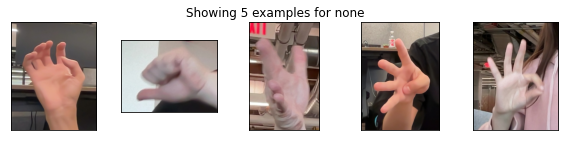

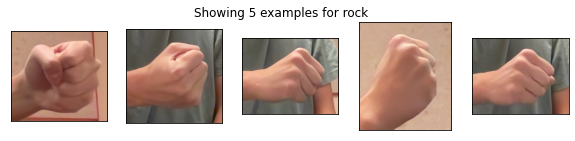

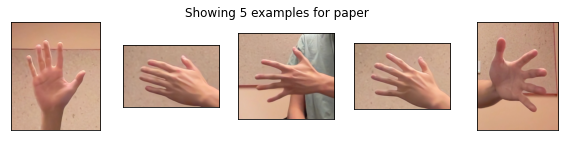

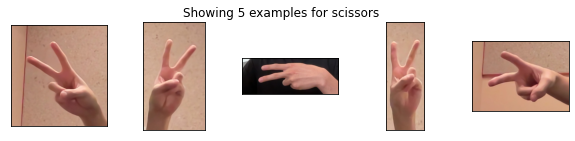

In [ ]:
import matplotlib.pyplot as plt
import os

NUM_EXAMPLES = 5
IMAGES_PATH = "rps_data_sample"

# Get the list of labels from the list of folder names.
labels = []
for i in os.listdir(IMAGES_PATH):
  if os.path.isdir(os.path.join(IMAGES_PATH, i)):
    labels.append(i)

# Show the images.
for label in labels:
  label_dir = os.path.join(IMAGES_PATH, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

Then let's install MediaPipe Model Maker, which we'll use to train a custom gesture recognizer.

In [ ]:
!pip install -q mediapipe-model-maker

     |████████████████████████████████| 7.0 MB 3.2 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 2.3 MB 61.2 MB/s 
     |████████████████████████████████| 1.7 MB 55.8 MB/s 
     |████████████████████████████████| 6.0 MB 60.8 MB/s 
     |████████████████████████████████| 439 kB 56.5 MB/s 
     |████████████████████████████████| 1.3 MB 49.0 MB/s 
     |████████████████████████████████| 5.8 MB 12.6 MB/s 
     |████████████████████████████████| 238 kB 50.5 MB/s 
     |████████████████████████████████| 1.1 MB 48.4 MB/s 
     |████████████████████████████████| 662 kB 55.3 MB/s 
     |████████████████████████████████| 118 kB 74.7 MB/s 
     |████████████████████████████████| 352 kB 73.0 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 38.2 MB 1.2 MB/s 


## Train a custom gesture recognizer

Now let's use MediaPipe Model Maker to train a rock-paper-scissors recognizer using our images.

In [ ]:
# Import the necessary modules.
from mediapipe_model_maker import gesture_recognizer

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
# Load the rock-paper-scissor image archive.
data = gesture_recognizer.Dataset.from_folder(
    dirname=IMAGES_PATH,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)

# Split the archive into training, validation and test dataset.
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# Train the model
hparams = gesture_recognizer.HParams(export_dir="rock_paper_scissors_model")
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer)  [(None, 128)]            0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 custom_gesture_recognizer (  (None, 4)                516       
 Dense)                                                          
                                                                 
Total params: 1,028
Trainable params: 772
Non-trainable param

The model accuracy is above 80% for both the training dataset and validation dataset, and it doesn't look like it's overfitting. Therefore, we proceed with testing it on the test dataset that the model hasn't seen before and see if we're also getting decent accuracy.

In [ ]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

48/48 [==============================] - 0s 2ms/step - loss: 0.3562 - categorical_accuracy: 0.7917
Test loss:0.3562448024749756, Test accuracy:0.7916666865348816


We're also getting about 80% accuracy on the test dataset, which is quite good.

## Export the custom solution for deployment

Now we've verified with the test dataset that the custom solution's accuracy is good enough. Let's export it as a model bundle for deployment.

*Note: This model bundle contains multiple TensorFlow Lite models that will be chained together to perform hand gesture recognition.*

In [ ]:
# Export the model bundle.
model.export_model()

# Rename the file to be more descriptive.
!mv rock_paper_scissors_model/gesture_recognizer.task rock_paper_scissors.task

You can also download the model bundle and try it out on MediaPipe Studio.

In [ ]:
from google.colab import files
files.download("rock_paper_scissors.task")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Then go to MediaPipe Studio's [Gesture Recognizer demo](https://mediapipe-studio.webapps.google.com/demo/gesture_recognizer) and upload the model bundle there.

![MediaPipe Studio upload bundle](https://storage.googleapis.com/khanhlvg_ml/wimls_22/upload_bundle.jpg)

# Step 5: Use the custom solution in Python with MediaPipe Tasks

Using the custom solution is very similar to using the off-the-shelf one. The only difference is which model bundle you specify when creating the GestureRecognizer object.

Let's start with confirming the input image that we're going to use.

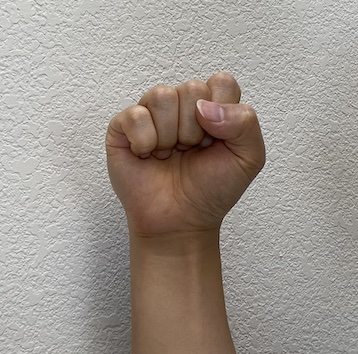

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread("photo.jpg")
cv2_imshow(img)

Now create a gesture recognizer using the rock-paper-scissors model bundle and recognize the gesture in the image.

In [ ]:
# Imports neccessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Create a GestureRecognizer object.
model_path = os.path.abspath("rock_paper_scissors.task")
recognizer = vision.GestureRecognizer.create_from_model_path(model_path)

# Load the input image.
image = mp.Image.create_from_file('photo.jpg')

# Run gesture recognition.
recognition_result = recognizer.recognize(image)

# Display the most likely gesture.
top_gesture = recognition_result.gestures[0][0]
print(f"Gesture recognized: {top_gesture.category_name} ({top_gesture.score})")

Gesture recognized: rock (0.999997615814209)


Hooray! You can see that it now recognizes the custom gesture (e.g. `rock`) instead of an off-the-shelf one (e.g. `closed fist`).

# Step 6: Try out the rock-paper-scissor demo game on the web

We've created a rock-paper-scissor demo game using MediaPipe Tasks and rock-paper-scissors gesture recognizer that we trained earlier. You can find it below:

* [Open the demo](https://codepen.io/mediapipe-preview/full/KKeybMr)
* Source code on [Codepen](https://codepen.io/mediapipe-preview/pen/KKeybMr)

Try it out and see if you can beat the computer!

![Rock paper scissors demo game](https://storage.googleapis.com/khanhlvg_ml/wimls_22/rock_paper_scissors_screenshot.jpg)

# Conclusion

MediaPipe has many more on-device ML solutions, including object detection, text classification etc. You can use MediaPipe Tasks to deploy the off-the-shelf solutions on many different platforms like web, Android or Python. MediaPipe Model Maker enables you to customize off-the-shelf solutions to support your specific use cases using your own dataset.

Check out these resources to learn more about what you can do with MediaPipe.
* Try out the solutions on [MediaPipe Studio](http://goo.gle/mediapipe-studio).
* See the [MediaPipe documentation](https://developers.google.com/mediapipe) to learn how to integrate or customize MediaPipe's on-device ML solutions.